reference : https://github.com/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/cnn.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.8.1].
device:[cuda:0].


#### Dataset : MNIST

In [2]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(root='./data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)
print ("mnist_train:\n",mnist_train,"\n")
print ("mnist_test:\n",mnist_test,"\n")
print ("Done.")

mnist_train:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor() 

mnist_test:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor() 

Done.


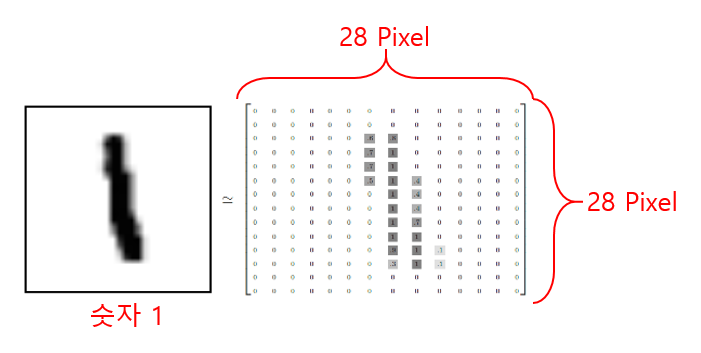

#### Data Iterator

In [3]:
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
print("Done.")

Done.


#### Define Model
1. nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding = 0,padding_mode='zeros', device=None)
2. nn.ReLU(inplace=False) #inplace란 계산 후 값이 이전 값을 대체하는 것이다. 
3. nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
4. nn.Dropout2d(p=0.5, inplace=False)

데이터로 들어오는 MNIST data는 위 그림과 같습니다. (28x28x1) 
1. model : (28x28x1) -> (14x14x32) -> (7x7x64) -> flatten -> 256 -> 128 -> 10

In [4]:
class CNN(nn.Module):
    def __init__(self, name='cnn', xdim=[1,28,28],
                ksize=3, cdims=[32,64], hdims=[1024,128], ydim=10,
                USE_BATCHNORM=False):
        super(CNN, self).__init__()
        self.name = name
        self.xdim = xdim
        self.ksize = ksize
        self.cdims = cdims
        self.hdims = hdims
        self.ydim = ydim
        self.USE_BATCHNORM = USE_BATCHNORM
        
        self.layers = []
        prev_cdim = self.xdim[0]
        
        for cdim in self.cdims: # for each hidden layers
            self.layers.append(
                ####
                nn.Conv2d(prev_cdim,
                          cdim,
                          kernel_size = self.ksize,
                          stride = (1,1),
                          padding = self.ksize//2       
                )
            )
            prev_cdim = cdim
            if self.USE_BATCHNORM:
                self.layers.append(nn.BatchNorm2d(cdim))
            self.layers.append(nn.ReLU(True))
            self.layers.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)))
            self.layers.append(nn.Dropout2d(p=0.5))
            self.cdim = cdim #next layer
        
        self.layers.append(nn.Flatten())
        prev_hdim = prev_cdim*(self.xdim[1]//(2**len(self.cdims)))*(self.xdim[2]//(2**len(self.cdims)))
        for hdim in self.hdims:
            ########
            self.layers.append(nn.Linear(prev_hdim, hdim))
            self.layers.append(nn.ReLU(True))
            prev_hdim = hdim
        # Final layer (without activation)    
        self.layers.append(nn.Linear(prev_hdim, self.ydim, bias=True))
        
        # Concat layers
        self.net = nn.Sequential()
        for l_idx, layer in enumerate(self.layers):
            layer_name = "%s_%02d"%(type(layer).__name__.lower(), l_idx)
            self.net.add_module(layer_name, layer)
        self.init_param()
        
    def init_param(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
                
    def forward(self, x):
        return self.net(x)

C = CNN(name='cnn', xdim=[1,28,28], ksize=3, cdims=[32,64], 
       hdims=[32], ydim=10).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(C.parameters(), lr=1e-3)
print('Done.')
        

Done.


In [12]:
print(C)

CNN(
  (net): Sequential(
    (conv2d_00): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_01): ReLU(inplace=True)
    (maxpool2d_02): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (dropout2d_03): Dropout2d(p=0.5, inplace=False)
    (conv2d_04): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_05): ReLU(inplace=True)
    (maxpool2d_06): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (dropout2d_07): Dropout2d(p=0.5, inplace=False)
    (flatten_08): Flatten(start_dim=1, end_dim=-1)
    (linear_09): Linear(in_features=3136, out_features=32, bias=True)
    (relu_10): ReLU(inplace=True)
    (linear_11): Linear(in_features=32, out_features=10, bias=True)
  )
)


#### Check Parameters

In [5]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx,(param_name,param) in enumerate(C.named_parameters()):
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy() # to numpy array 
        n_param += len(param_numpy.reshape(-1))
        print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
        print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

[0] name:[net.conv2d_00.weight] shape:[(32, 1, 3, 3)].
    val:[-0.724 -0.059  0.377 -0.337  0.041]
[1] name:[net.conv2d_00.bias] shape:[(32,)].
    val:[0. 0. 0. 0. 0.]
[2] name:[net.conv2d_04.weight] shape:[(64, 32, 3, 3)].
    val:[ 0.043 -0.024  0.145 -0.126  0.041]
[3] name:[net.conv2d_04.bias] shape:[(64,)].
    val:[0. 0. 0. 0. 0.]
[4] name:[net.linear_09.weight] shape:[(32, 3136)].
    val:[ 0.014 -0.018 -0.02   0.     0.027]
[5] name:[net.linear_09.bias] shape:[(32,)].
    val:[0. 0. 0. 0. 0.]
[6] name:[net.linear_11.weight] shape:[(10, 32)].
    val:[ 0.035  0.363  0.666 -0.057  0.169]
[7] name:[net.linear_11.bias] shape:[(10,)].
    val:[0. 0. 0. 0. 0.]
Total number of parameters:[119,530].


#### Forward Path of CNN model

In [6]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
x_numpy = np.random.rand(2,1,28,28)
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = C.forward(x_torch) # forward path
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy array
print ("x_torch:\n",x_torch)
print ("y_torch:\n",y_torch)
print ("\nx_numpy %s:\n"%(x_numpy.shape,),x_numpy)
print ("y_numpy %s:\n"%(y_numpy.shape,),y_numpy)

x_torch:
 tensor([[[[0.810, 0.468, 0.548,  ..., 0.355, 0.419, 0.420],
          [0.276, 0.226, 0.208,  ..., 0.035, 0.031, 0.619],
          [0.467, 0.461, 0.934,  ..., 0.036, 0.257, 0.339],
          ...,
          [0.371, 0.983, 0.089,  ..., 0.622, 0.609, 0.210],
          [0.595, 0.076, 0.023,  ..., 0.079, 0.043, 0.455],
          [0.954, 0.504, 0.266,  ..., 0.181, 0.969, 0.023]]],


        [[[0.698, 0.783, 0.133,  ..., 0.576, 0.932, 0.566],
          [0.908, 0.611, 0.848,  ..., 0.663, 0.672, 0.735],
          [0.670, 0.580, 0.280,  ..., 0.273, 0.732, 0.296],
          ...,
          [0.827, 0.386, 0.049,  ..., 0.611, 0.397, 0.746],
          [0.198, 0.552, 0.075,  ..., 0.411, 0.887, 0.955],
          [0.165, 0.665, 0.385,  ..., 0.326, 0.137, 0.654]]]], device='cuda:0')
y_torch:
 tensor([[-0.385,  1.162,  2.594, -0.889,  1.739, -0.878,  0.260, -2.659, -0.253,
         -1.090],
        [ 1.950, -1.438,  1.999,  0.776,  2.788,  0.354, -1.865, -0.959,  1.665,
          3.963]], device=

In [7]:
def func_eval(model,data_iter,device):
    with torch.no_grad():
        n_total,n_correct = 0,0
        model.eval() # evaluate (affects DropOut and BN)
        for batch_in,batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model(batch_in.view(-1,1,28,28).to(device))
            _,y_pred = torch.max(model_pred.data,1)
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train() # back to train mode 
    return val_accr
print ("Done")

Done


In [8]:
C.init_param() # initialize parameters
train_accr = func_eval(C,train_iter,device)
test_accr = func_eval(C,test_iter,device)
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))

train_accr:[0.099] test_accr:[0.096].


gpu cache를 비워주는 역할을 한다.

In [9]:
import gc
gc.collect()
torch.cuda.empty_cache()

#### Train

In [11]:
print ("Start training.")
C.init_param() # initialize parameters
C.train() # to train mode 
EPOCHS,print_every = 10,1
for epoch in range(EPOCHS):

    loss_val_sum = 0
    for batch_in,batch_out in train_iter:
        # Forward path
        y_pred = C.forward(batch_in.view(-1,1,28,28).to(device))
        loss_out = loss(y_pred,batch_out.to(device))
        # Update
        optm.zero_grad()     # reset gradient 
        loss_out.backward()     # backpropagate
        optm.step()     # optimizer update
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_iter)
    # Print
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_accr = func_eval(C,train_iter,device)
        test_accr = func_eval(C,test_iter,device)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
               (epoch,loss_val_avg,train_accr,test_accr))
print ("Done")

Start training.
epoch:[0] loss:[0.694] train_accr:[0.949] test_accr:[0.949].
epoch:[1] loss:[0.205] train_accr:[0.971] test_accr:[0.973].
epoch:[2] loss:[0.133] train_accr:[0.979] test_accr:[0.980].
epoch:[3] loss:[0.108] train_accr:[0.982] test_accr:[0.982].
epoch:[4] loss:[0.094] train_accr:[0.985] test_accr:[0.984].
epoch:[5] loss:[0.083] train_accr:[0.987] test_accr:[0.987].
epoch:[6] loss:[0.075] train_accr:[0.988] test_accr:[0.986].
epoch:[7] loss:[0.068] train_accr:[0.989] test_accr:[0.987].
epoch:[8] loss:[0.065] train_accr:[0.989] test_accr:[0.987].
epoch:[9] loss:[0.062] train_accr:[0.991] test_accr:[0.988].
Done


#### Test

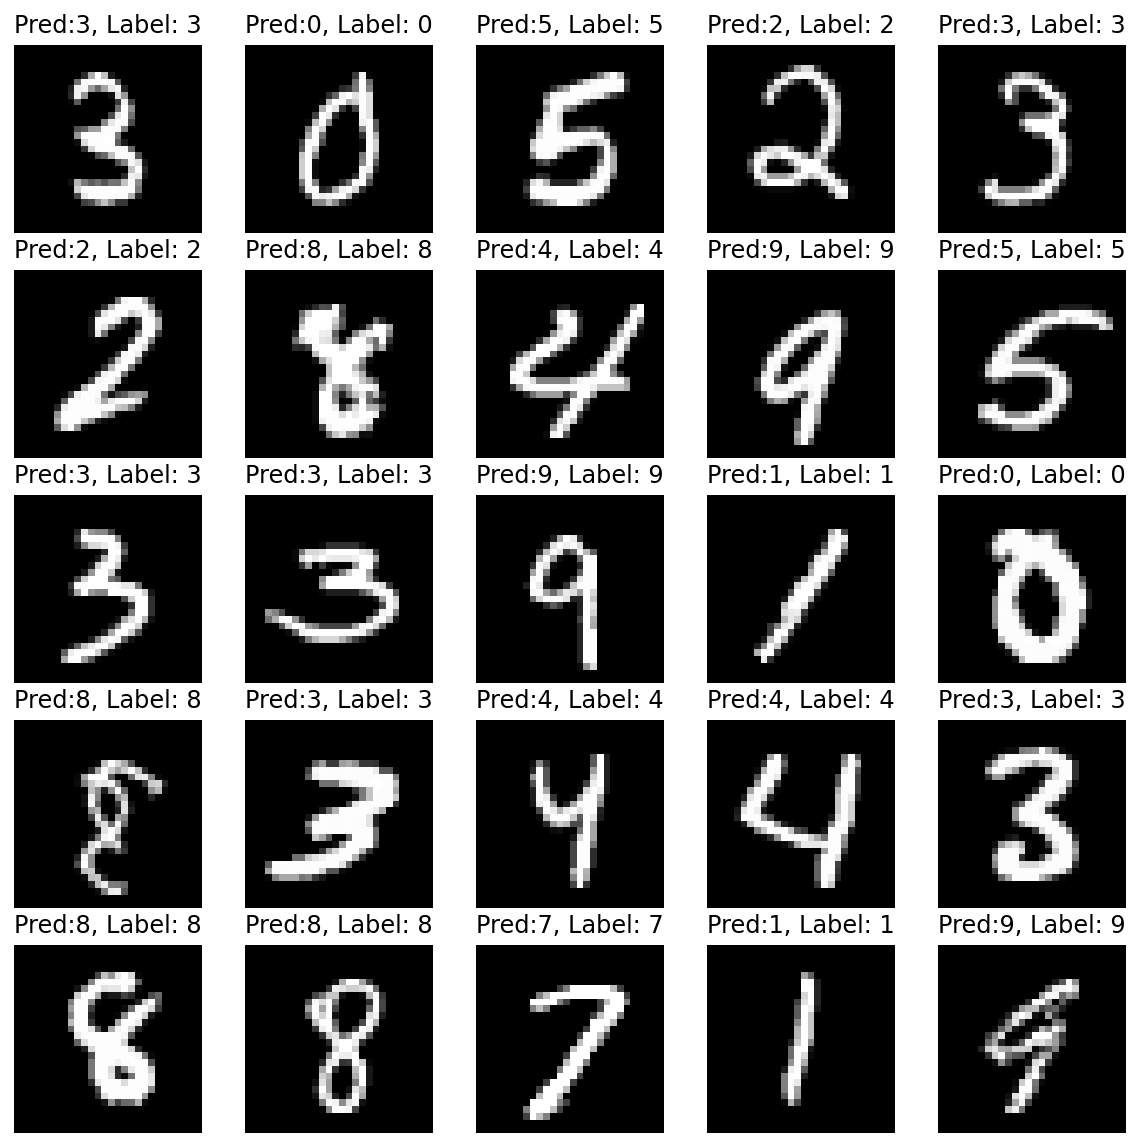

Done


In [17]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets), n_sample, replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]

with torch.no_grad():
    C.eval()
    y_pred = C.forward(test_x.view(-1, 1, 28, 28).type(torch.float).to(device))
y_pred = y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5,5,idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label: %d"%(y_pred[idx], test_y[idx]))
plt.show()
print("Done")